In [13]:
import sys
sys.path.append("../src")

import os

import cv2
import imgviz
import pyvips
import numpy as np
import matplotlib.pyplot as plt
from utils import (
    pad_img,
    get_args, 
    patchify,
    save_patches,
    save_patch_args, 
    get_target_dim,
    )

In [14]:
data_dir = os.path.join("..", "..", "data", "images")
image_names = os.listdir(data_dir)

print("num images:", len(image_names))

num images: 127


In [15]:
image_paths = [os.path.join(data_dir, i) for i in image_names]

In [16]:
slide = pyvips.Image.new_from_file(image_paths[0])

In [17]:
wsi = slide.numpy()

wsi.shape

(23663, 21566, 3)

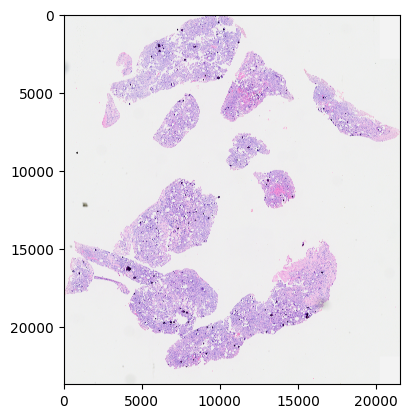

In [18]:
plt.imshow(wsi)
plt.show()

In [19]:
target = 224

target_shape = get_target_dim(wsi, target)

if target_shape != wsi.shape[:2]:
    test_img = wsi.copy()
    test_img = pad_img(test_img, target_shape)

In [20]:
# img_patches, cords = patchify(wsi, 224, 0.0)

In [21]:
target_shape

(23744, 21728)

<function matplotlib.pyplot.show(close=None, block=None)>

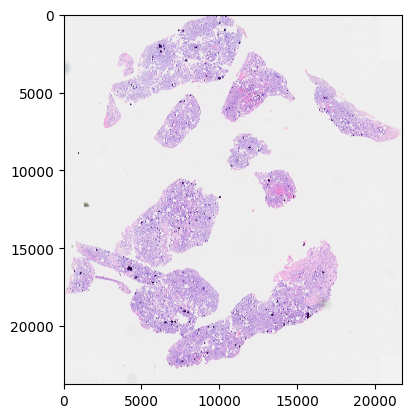

In [22]:
plt.imshow(test_img)
plt.show()

In [24]:
plt.imsave("test.png", test_img)

In [25]:
test_img.shape

(23743, 21728, 3)